<a href="https://colab.research.google.com/github/cezargfilho/amazon-activefire-cnn/blob/main/CNN_AMAZON_LANDSAT8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações de Bibliotecas

No pré-processamento do dataset foram utilizadas as seguintes bibliotecas:


*   [Rasterio](https://github.com/rasterio/rasterio)
*   [Gdown](https://github.com/wkentaro/gdown)

In [ ]:
# Instalação do gdown
!pip install rasterio
!pip3 install gdown
!pip install --upgrade gdown
#!pip list
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip install opencv-python matplotlib

In [ ]:
import tensorflow as tf
import os

# Ativação de GPU (Depreciado)

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Baixar o dataset do Google Drive (Opção 1 - Método Público)

In [ ]:
# Se faz necessário colocar o ID pertencente ao arquivo público no Google Drive:
!gdown 1oO4BK-FnLlubSKFe9ejtUrSNZBz72L4w

# Brazil-amazon-fire.zip:
# Link = https://drive.google.com/file/d/1oO4BK-FnLlubSKFe9ejtUrSNZBz72L4w/view?usp=sharing
# archiveId = 1oO4BK-FnLlubSKFe9ejtUrSNZBz72L4w

# Brazil-amazon-nonfire.zip:
# Link = https://drive.google.com/file/d/1mROdPOPw-GMz5KsAwfKbn5mdkJ92neQ4/view?usp=sharing
# archiveId = 1mROdPOPw-GMz5KsAwfKbn5mdkJ92neQ4

Downloading...
From (uriginal): https://drive.google.com/uc?id=1oO4BK-FnLlubSKFe9ejtUrSNZBz72L4w
From (redirected): https://drive.google.com/uc?id=1oO4BK-FnLlubSKFe9ejtUrSNZBz72L4w&confirm=t&uuid=25e3d629-747c-4e46-8a50-a674540393e4
To: /content/Brazil-amazon-fire.zip
100% 24.8G/24.8G [04:37<00:00, 89.4MB/s]


In [ ]:
!unzip Brazil-amazon-fire.zip
!rm -f Brazil-amazon-fire.zip
!unzip '*.zip'
!rm -f *.zip

In [ ]:
import shutil
import os
    
source_dir = '/content/'
target_dir = './unziped/'
    
file_names = [file for file in os.listdir(source_dir) if file.endswith('.tif')]

if not os.path.exists(target_dir):
      os.makedirs(target_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

print('total:', len(os.listdir(target_dir)))

total: 85681


# Pré Processamento

## Função de transformação

Esta função tem como objetivo a transformação de uma imagem '.tif' para uma imagem '.png' com apenas 3 canais (RGB).

### Parâmetros

- `IMAGE`: O caminho do arquivo de imagem no formato `'.tif'`.
- `OUTPUT_IMAGE_NAME`: O nome do arquivo de saída, que será uma imagem no formato `'.png'`.

### Bibliotecas

- `rasterio`
- `numpy`
- `os`
- `cv2`

### Passos principais

1. Define a variável `OUTPUT_DIR` com o caminho do diretório onde a imagem de saída será armazenada.
2. Define a variável `MAX_PIXEL_VALUE` com o valor máximo de um pixel na imagem, que será utilizado para normalizar a imagem. O valor `MAX_PIXEL_VALUE = 65535` é usado para normalizar a imagem porque este é o valor máximo que um pixel pode ter em uma imagem de satélite do tipo Landsat 8.
3. Substitui a extensão do arquivo de saída de `'.tif'` para `'.png'`.
4. Define a função interna `get_img_762bands`, que recebe como parâmetro o caminho da imagem `'.tif'` e retorna a imagem nas bandas 7, 6 e 2 no formato `(altura, largura, canais)` e normalizada.
5. Verifica se o diretório de saída existe, caso contrário, cria o diretório.
6. Chama a função `get_img_762bands` para obter a imagem normalizada.
7. Multiplica a imagem normalizada por 255 e converte para `uint8`.
8. Salva a imagem no formato `'.png'` no diretório de saída, convertendo-a de `RGB` para `BGR`.


In [ ]:
import rasterio
import numpy as np
import os
import cv2

def transform_image(IMAGE, OUTPUT_IMAGE_NAME):
  OUTPUT_DIR = '/content/dataset_output'
  MAX_PIXEL_VALUE = 65535 # Max. pixel value, used to normalize the image
  OUTPUT_IMAGE_NAME = OUTPUT_IMAGE_NAME.replace('.tif', '.png')
  def get_img_762bands(path):
      img = rasterio.open(path).read((7,6,2)).transpose((1, 2, 0))      
      img = np.float32(img)/MAX_PIXEL_VALUE #Normalização da imagem faz o pixel da imagem ficar entre 0 e 1 
      
      return img
          

  if not os.path.exists(OUTPUT_DIR):
      os.makedirs(OUTPUT_DIR)

  img = get_img_762bands(IMAGE)
  #plt.imshow(img)

  img = np.array(img * 255, dtype=np.uint8)
  cv2.imwrite(os.path.join(OUTPUT_DIR, OUTPUT_IMAGE_NAME), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# Função para percorrer um diretório com imagens

Percorre o diretório do dataset chamando a função de transformação para cada imagem.

### Parâmetros

- `path`: O caminho do diretório que contém as imagens no formato `'.tif'`.

### Passos principais

1. Cria uma lista `paths` que contém o caminho completo de todas as imagens no diretório especificado em `path`.
2. Cria uma lista `file_names` com o nome de todas as imagens no diretório especificado em `path`.
3. Obtém o tamanho da lista `paths`.
4. Itera sobre cada imagem em `paths` e chama a função `transform_image` com os parâmetros `IMAGE` definido como o caminho da imagem em `paths[i]` e `OUTPUT_IMAGE_NAME` definido como o nome da imagem em `file_names[i]` substituindo a extensão `'.tif'` para `'.png'`.

### Observação

Certifique-se de que o caminho especificado em `path` contém apenas imagens no formato `'.tif'`. Caso contrário, pode ocorrer um erro ao chamar a função `transform_image`.


In [ ]:
path = '/content/unziped/'
paths = [os.path.join(path, nome) for nome in os.listdir(path)]
file_names = os.listdir(path)
size = len(paths)
print(size)

for i in range(0, size):
  transform_image(IMAGE = paths[i], OUTPUT_IMAGE_NAME = file_names[i])

85681


In [ ]:
# Remove imagens .TIF
!rm -fr ./unziped

## Aumento de Dados (Data Augmentation)

O aumento de dados (data augmentation) é uma técnica utilizada para aumentar a quantidade de dados em um conjunto de dados de treinamento. Esta técnica é muito útil em tarefas de aprendizado de máquina quando há poucos dados disponíveis e o modelo precisa ser treinado com mais exemplos para evitar o sobreajuste (overfitting). 

Neste bloco de código, utilizamos a biblioteca `Augmentor` para realizar o aumento de dados nas imagens de treinamento. As transformações realizadas foram:

- `rotate`: Rotaciona a imagem em um ângulo aleatório entre `-10` e `10` graus.
- `flip_top_bottom`: Virar verticalmente a imagem com probabilidade de `0.5`.
- `flip_left_right`: Virar horizontalmente a imagem com probabilidade de `0.5`.

### Biblioteca

- `Augmentor`

### Passos principais

1. Cria um objeto `p` do tipo `Augmentor.Pipeline` com o caminho do diretório que contém as imagens de treinamento.
2. Adiciona a transformação `rotate` com um ângulo máximo de rotação de `10` graus para esquerda e `10` graus para a direita.
3. Adiciona a transformação `flip_top_bottom` para virar verticalmente a imagem com probabilidade de `0.5`.
4. Adiciona a transformação `flip_left_right` para virar horizontalmente a imagem com probabilidade de `0.5`.
5. Gera `18219` novas imagens utilizando a função `sample` do objeto `p`.
6. Aplica as transformações geradas às imagens de treinamento com a função `process` do objeto `p`.

### Observação

A transformação `zoom` foi comentada pela perda de pixels, mas pode ser utilizada descomentando a linha `p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)` e ajustando os parâmetros conforme necessário caso encontre uma possibilidade. Além disso, outras transformações podem ser adicionadas para aumentar ainda mais a diversidade dos dados de treinamento.


In [ ]:
!pip  install  Augmentor

In [ ]:
import Augmentor

p = Augmentor.Pipeline('./dataset_brazil_amazon_v2/train/1/')
p.rotate(probability=1, max_left_rotation=10, max_right_rotation=10)
# p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.flip_top_bottom(0.5) # 
# p.flip_left_right(0.5)

p.sample(18219)

p.process()

## Separação de Dados de Treinamento e Teste

Este bloco de código tem como objetivo separar as imagens em dois conjuntos de dados distintos: um conjunto para treinamento e outro conjunto para teste. A proporção escolhida para esta separação foi de 80% para treinamento e 20% para teste.

### Parâmetros

- `OUT_DIR`: O caminho do diretório que contém as imagens que serão separadas.
- `train_qtd`: A quantidade de imagens que será utilizada para o conjunto de dados de teste.

### Passos principais

1. Cria uma lista `DIR_LIST` que contém todos os arquivos no diretório especificado em `OUT_DIR`.
2. Calcula a quantidade de imagens que serão utilizadas para o conjunto de dados de treinamento e teste, respectivamente.
3. Cria uma lista `files_list` que contém o caminho completo de todas as imagens no diretório especificado em `OUT_DIR`.
4. Itera sobre cada arquivo em `files_list` e adiciona à lista `filesToCopy` se o arquivo termina com a extensão `'.png'`.
5. Seleciona aleatoriamente `train_qtd` imagens da lista `filesToCopy` para serem movidas para o diretório de teste.
6. Move cada imagem selecionada na etapa anterior para o diretório de teste especificado em `destPath`.

### Observação

Certifique-se de que o caminho especificado em `OUT_DIR` contém apenas imagens no formato `'.png'`. Caso contrário, pode ocorrer um erro ao selecionar as imagens para o conjunto de dados de teste. Além disso, é importante que o diretório de teste (`destPath`) já exista antes de executar este bloco de código.


In [ ]:
# Cria estrutura padrão
!mkdir -p dataset_amazon/train/0
!mkdir -p dataset_amazon/train/1
!mkdir -p dataset_amazon/test/0
!mkdir -p dataset_amazon/test/1

In [ ]:
import os
import random
import shutil

# Calcula a 80% treino / 20% teste
OUT_DIR = '/content/dataset_output'
DIR_LIST = os.listdir(OUT_DIR)

train_qtd = int(len(DIR_LIST)*.2)


files_list = []

for root, dirs, files in os.walk(OUT_DIR):
    for file in files:
        #all 
        if file.endswith(".png"):
            files_list.append(os.path.join(root, file))

#print images
#lets me count and print the amount of jpeg,jpg,pmg 
file_count = len(files_list)
print('total files: ', file_count)

# print files_list   
filesToCopy = random.sample(files_list, train_qtd)  #prints two random files from list 

destPath = 'dataset_amazon/test/1'

# iteraate over all random files and move them
for file in filesToCopy:
    shutil.move(file, destPath)

total files:  68541


In [ ]:
# move train files to destiny folder
destination = 'dataset_amazon/train/1'

# iterate on all files to move them to destination folder
for file in DIR_LIST:
  src_path = os.path.join(OUT_DIR, file)
  dst_path = os.path.join(destination, file)
  shutil.move(src_path, dst_path)

In [ ]:
print('total test 1:', len(os.listdir('/content/dataset_amazon/test/1')))
print('total train 1:', len(os.listdir('/content/dataset_amazon/train/1')))
print('total output:', len(os.listdir('/content/dataset_output')))
print('total test 0:', len(os.listdir('/content/dataset_amazon/test/0')))
print('total train 0:', len(os.listdir('/content/dataset_amazon/train/0')))

total test 1: 0
total train 1: 0
total output: 85681
total test 0: 0
total train 0: 0


# Realiza Upload de imagens transformadas para o Google Drive

In [ ]:
from google.colab import drive


In [ ]:
!zip -r 'dataset_venezuela.zip' '/content/dataset_venezuela'

In [ ]:
!mv '/content/dataset_venezuela.zip' /content/drive/MyDrive/DATASET_AMAZON/

In [ ]:
drive.flush_and_unmount()

# Dataset

Dataset original: [A Large-Scale Dataset for Active Fire Detection/Segmentation (Landsat-8)](https://ieee-dataport.org/open-access/large-scale-dataset-active-fire-detectionsegmentation-landsat-8)

O dataset utilizado neste projeto sofreu os pré-processamentos a seguir:

*   Captura de três dos onze canais (RGB);
*   Balanceamento da classe incêndio utilizando Data Augmentation;



Baixar o modificado: https://drive.google.com/file/d/zYgZkCN_UhhxJmR7N8Kr7qJBVS/view?usp=sharing

# Dowload e carga do dataset

In [ ]:
# Download do dataset pré-processado
## Balanceado e imagens em RGB
!gdown --id 128poiyl73Uxl4YqvwdJsmUaM47M-AVbe
!unzip dataset_brazil_amazon_v5.zip
!rm -f dataset_brazil_amazon_v5.zip

In [ ]:
!mkdir data
!mkdir data/0
!mkdir data/1

In [ ]:
!cp -r /content/dataset_brazil_amazon_v5/test/0 /content/data/0
!cp -r /content/dataset_brazil_amazon_v5/train/0 /content/data/0

In [ ]:
!cp -r /content/dataset_brazil_amazon_v5/test/1 /content/data/1
!cp -r /content/dataset_brazil_amazon_v5/train/1 /content/data/1

In [ ]:
import numpy as np
from matplotlib import pyplot as plt


In [ ]:
#First find where the ".ipynb_checkpoints" is located.

train_dir = os.listdir("/content/dataset_brazil_amazon_v5/train") 
test_dir = os.listdir("/content/dataset_brazil_amazon_v5/test")
print(train_dir, test_dir)

['0', '1', '.ipynb_checkpoints'] ['0', '1', '.ipynb_checkpoints']


In [ ]:
# Remove directories /.ipynb_checkpoints
import shutil

shutil.rmtree("/content/dataset_brazil_amazon_v5/train/.ipynb_checkpoints")
shutil.rmtree("/content/dataset_brazil_amazon_v5/test/.ipynb_checkpoints")

## Definição dos Hiperparâmetros

Este bloco de código tem como objetivo definir os hiperparâmetros que serão utilizados no modelo de aprendizado de máquina.

### Parâmetros

- `TRAIN_FOLDER`: O caminho do diretório que contém as imagens de treinamento.
- `TEST_FOLDER`: O caminho do diretório que contém as imagens de teste.
- `SPLIT_RATE`: A proporção utilizada para separar as imagens de treinamento e teste. O valor padrão é `0.8`.
- `IMAGE_HEIGHT`: A altura das imagens que serão utilizadas no modelo.
- `IMAGE_WIDTH`: A largura das imagens que serão utilizadas no modelo.
- `NUM_CHANNELS`: O número de canais das imagens que serão utilizadas no modelo. O valor padrão é `3`.
- `BATCH_SIZE`: O tamanho do lote utilizado durante o treinamento. O valor padrão é `32`.
- `LEARNING_RATE`: A taxa de aprendizado utilizada durante o treinamento.
- `LOSSES`: A função de perda utilizada durante o treinamento.
- `OPTIMIZER`: O otimizador utilizado durante o treinamento.

### Observação

Os hiperparâmetros podem ser ajustados conforme necessário para otimizar o modelo de aprendizado de máquina. Além disso, é importante que os caminhos especificados em `TRAIN_FOLDER` e `TEST_FOLDER` correspondam aos diretórios que contêm as imagens de treinamento e teste, respectivamente.


In [ ]:
#Hiperparametros
TRAIN_FOLDER = '/content/dataset_brazil_amazon_v5/train'
TEST_FOLDER = '/content/dataset_brazil_amazon_v5/test'
SPLIT_RATE = 0.8

IMAGE_HEIGHT = 128  # height of the image
IMAGE_WIDTH = 128   # width of the image
NUM_CHANNELS = 3   # number of channels of the image
BATCH_SIZE = 32
LEARNING_RATE = 0.001
LOSSES = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
#LOSSES = tf.losses.BinaryCrossentropy()
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate= LEARNING_RATE)

## Carregamento dos Dados de Treinamento

Este bloco de código tem como objetivo carregar as imagens de treinamento em um objeto `tf.data.Dataset` utilizando o método `image_dataset_from_directory` da biblioteca TensorFlow.

### Parâmetros

- `TRAIN_FOLDER`: O caminho do diretório que contém as imagens de treinamento.
- `IMAGE_HEIGHT`: A altura das imagens que serão utilizadas no modelo.
- `IMAGE_WIDTH`: A largura das imagens que serão utilizadas no modelo.
- `BATCH_SIZE`: O tamanho do lote utilizado durante o treinamento.

### Keras

Neste trabaho, a biblioteca Keras será utilizada para construir uma Rede Neural Convolucional (CNN) que será treinada para classificar imagens como apresentando ou não foco de incêndio na Amazônia. O conjunto de dados contém imagens de satélite do projeto Landsat8. As imagens serão pré-processadas e divididas em conjuntos de treinamento e teste. Em seguida, um modelo CNN será definido utilizando camadas convolucionais, de pooling e densas. O modelo será compilado com uma função de perda, um otimizador e métricas de avaliação. O modelo será treinado com os dados de treinamento e validado com os dados de teste. Por fim, o modelo será avaliado utilizando as métricas de avaliação definidas e será salvo para uso posterior.


In [ ]:
#LOAD TREINO
train_data = tf.keras.utils.image_dataset_from_directory(directory=TRAIN_FOLDER, image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size = BATCH_SIZE)

Found 137090 files belonging to 2 classes.


In [ ]:
# LOAD TESTE
test_data = tf.keras.utils.image_dataset_from_directory(directory=TEST_FOLDER, image_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

In [ ]:
# LOAD FROM DATA
#DATA_FOLDER = '/content/data'
#train_data = tf.keras.utils.image_dataset_from_directory(directory=DATA_FOLDER, image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size = BATCH_SIZE)

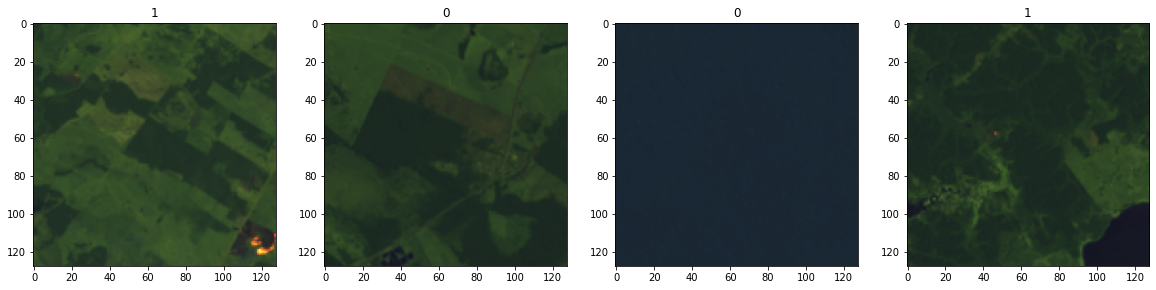

In [ ]:
# Plotando Imagens
data_iterator = train_data.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    ax[idx].axis("off")

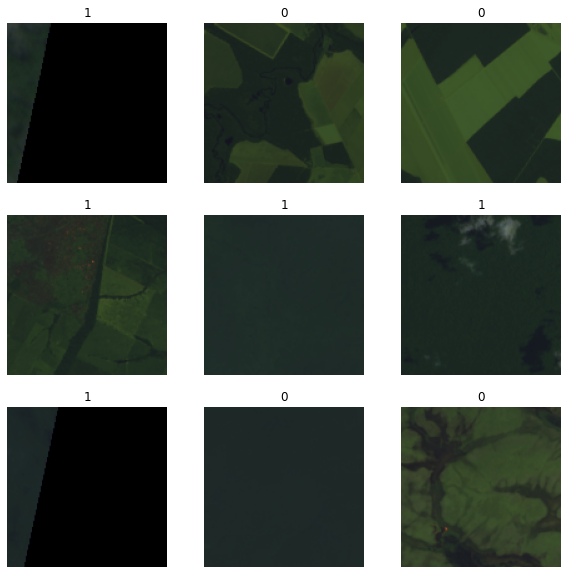

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(batch[1][i])
    plt.axis("off")

## Redimensionamento das Imagens

Estes blocos de código tem como objetivo redimensionar as imagens de treinamento e teste.

### Parâmetros

- `train_data`: O objeto `tf.data.Dataset` que contém as imagens de treinamento.
- `test_data`: O objeto `tf.data.Dataset` que contém as imagens de teste.

### Observação

A função `map` é utilizada para aplicar uma função lambda que normaliza as imagens dividindo-as por 255. Isso é necessário para que os valores dos pixels das imagens estejam no intervalo de 0 a 1.


In [ ]:
data_train = train_data.map(lambda x,y: (x/255, y))

In [ ]:
data_test = test_data.map(lambda x,y: (x/255, y))

In [ ]:
train_data_iterator = data_train.as_numpy_iterator()

In [ ]:
data_train.as_numpy_iterator().next()
#data_test.as_numpy_iterator().next()

In [ ]:
# Capturar 20% do train para validacao, ja que 10% está em teste
# train_size = int(len(data_train)*.8)
#val_size = int(len(data_train)*.2)
#test_size = int(len(data_test))

train_size = int(len(data_train)*.7)
val_size = int(len(data_train)*.2)
test_size = int(len(data_train)*.1)

In [ ]:
print(train_size)
print(val_size)
print(test_size)

3848
1099
549


In [ ]:
train = data_train.take(train_size)
val = data_train.skip(train_size).take(val_size)
test = data_train.take(test_size)

In [ ]:
## Aqui utilizar os classificadores KNN e SVM (Criar novo colab)
train

In [ ]:
print(len(train))
print(len(val))
print(len(test))

# Definição da Rede Neural Convolucional

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
#input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH, 3)

model.add(Conv2D(64,(3,3), padding='valid', activation='relu', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH, NUM_CHANNELS)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(512, activation=tf.nn.relu))
model.add(Dense(2, activation=tf.nn.softmax))

In [ ]:
#Teste de Arquitetura
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [ ]:
metrics_list = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        #tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        #tf.keras.metrics.AUC(name='auc'),
        #tf.keras.metrics.Precision(name='precision'),
        #tf.keras.metrics.Recall(name='recall'),
    ]

In [ ]:
model.compile(
    loss=LOSSES,
    optimizer=OPTIMIZER,
      metrics= metrics_list
      )

In [ ]:
model.summary()

# Treino

In [ ]:
!rm -rf 'logs'

In [ ]:
!mkdir /content/logs

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

# Plotando performance

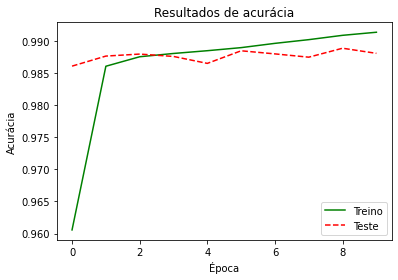

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, color='green', label='Treino')
plt.plot(epochs, val_acc, 'r--', label='Teste')
plt.title('Resultados de acurácia')
plt.legend(loc='lower right') # 'upper left', 'upper right', 'lower left', 'lower right')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.figure()
plt.show()

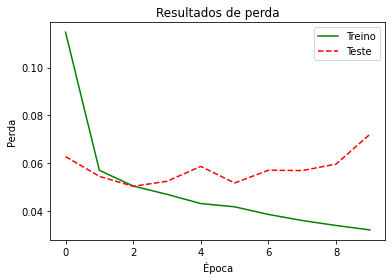

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, color='green', label='Treino')
plt.plot(epochs, val_loss, 'r--', label='Teste')
plt.title('Resultados de perda')
plt.legend(loc='upper right') # 'upper left', 'upper right', 'lower left', 'lower right')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.figure()
plt.show()

# Avaliar rede

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9968074, shape=(), dtype=float32) tf.Tensor(0.98711944, shape=(), dtype=float32) tf.Tensor(0.99220175, shape=(), dtype=float32)


# Teste

In [ ]:
import cv2

In [ ]:
# Importando Dataset Venezuela

!gdown --id 1u_SDFRME8TGdO5TketUcthoseiBI1sOI
!unzip dataset_venezuela.zip
!rm -f dataset_venezuela.zip

In [ ]:
!mv /content/content/dataset_venezuela /content/dataset_venezuela

In [ ]:
!rm -r /content/content

In [ ]:
!ls -1 /content/dataset_venezuela/0 | wc -l 

39893


In [ ]:
!mv /content/dataset_venezuela/0/LC08_L1GT_001053_20180519_20180520_01_RT_bands_n_s128_p01017.png.gz teste/

In [ ]:
!gzip -d /content/dataset_venezuela/0/LC08_L1GT_001053_20180519_20180520_01_RT_bands_n_s128_p00545.png.gz

In [ ]:
# OK Importar o Dataset da VENEZUELA RGB
# capturar 20 imagens (10 fire / 10 no fire)
# Se der, plotar as imagens com a classe
# fazer o Evaluate e verificar quantas a rede acerta

img = cv2.imread('teste.png')
plt.imshow(img)
plt.show()

In [ ]:
#LOAD EVALUATE
EVALUATE_FOLDER = '/content/dataset_venezuela'
eval_data = tf.keras.utils.image_dataset_from_directory(directory=EVALUATE_FOLDER, image_size=(128, 128), batch_size = 32)

Found 81840 files belonging to 2 classes.


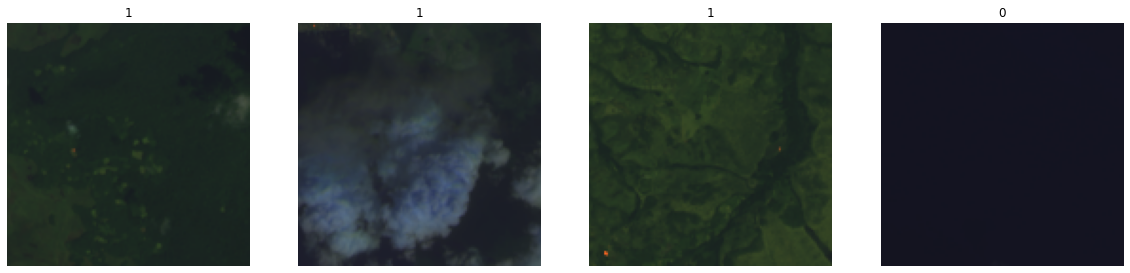

In [ ]:
# Plotando Imagens
eval_iterator = eval_data.as_numpy_iterator()
batch_eval = eval_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch_eval[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch_eval[1][idx])
    ax[idx].axis("off")

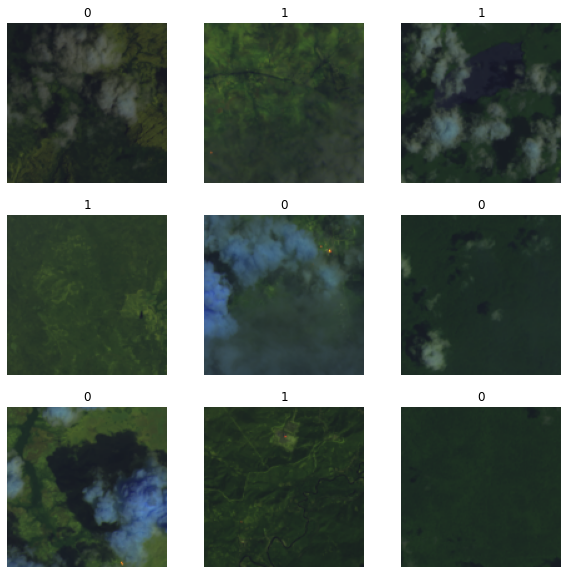

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in eval_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(batch[1][i])
    plt.axis("off")

In [ ]:
resize = tf.image.resize(img, (128,128))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
data_eval = eval_data.map(lambda x,y: (x/255, y))

data_eval.as_numpy_iterator().next()

In [ ]:
eval_array = data_eval.as_numpy_iterator().next()

In [ ]:
# Capturando os Labes e Imagens em array
eval_labels = eval_array[1]
eval_imgs = eval_array[0]

In [ ]:
#Capturando 20 imagens e 20 classes
imgs = eval_imgs[:20]
labels = eval_labels[:20]

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 17ms/step


In [ ]:
yhat

array([[0.00874092]], dtype=float32)

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Fire')
else:
    print(f'Predicted class is No Fire')

Predicted class is No Fire


# Salvar e exportar modelo

In [ ]:
from keras.models import load_model

In [ ]:
model.save(os.path.join('models','amazon_fire.h5'))
model.save_weights(os.path.join('models','amazon_weights.tf'))

In [ ]:
# Leitura do modelo salvo
new_model = load_model('amazon_fire.h5')

In [ ]:
# Realizar predição
new_model.predict(np.expand_dims(resize/255, 0))